In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
import re
import requests
import csv
import tensorflow as tf
import math
import random


from sklearn.metrics import confusion_matrix,  multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils import img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.layers import BatchNormalization, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping

**Sequence class for data load**

In [22]:
class Dataset(Sequence):
    def __init__(self, paths: str, batch_size: int):
        super(Dataset, self).__init__()
        self.batch_size = batch_size
        self.__data = paths
        self.classes = []
        self.__labels = self.__list_labels(self.__data)



    def __len__(self):
        return math.ceil(len(self.__data) / self.batch_size)

    def __getitem__(self, idx):
        batch_x = self.__data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.__labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([self.__load_image(i) for i in batch_x]), np.array(batch_y)

    def __list_labels(self, paths: list):
        labels = []
        for path in paths:
            label = path.split(os.path.sep)[-2].split('_')
            labels.append(label)

        mlb = MultiLabelBinarizer()
        labels = mlb.fit_transform(labels)
        self.classes = mlb.classes_

        return labels

    @staticmethod
    def __load_image(path: str):
        img = cv.imread(path)
        img = cv.resize(img, (224,224))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        return img / 255.0

split Training and testing path

In [3]:
train_size = 0.8
paths = []
path_to_subset = '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark'
for folder in os.listdir(path_to_subset):

    for image in os.listdir(os.path.join(path_to_subset, folder)):
        path_to_image = os.path.join(path_to_subset, folder, image)

        #check image none or not none
        img = cv.imread(path_to_image)
        if img is not None:
          paths.append( path_to_image)

paths = sorted(paths)
paths[0]
random.shuffle(paths)
assert 0.0 < train_size <= 1.0
thresh = round(len(paths) * train_size)
train_paths = paths[:thresh]
test_paths = paths[thresh:]
print(train_paths[0], test_paths[1])

/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/U/u_31_rotate_4.jpeg /content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/B/58.jpg


In [4]:
print(paths)

['/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/U/u_31_rotate_4.jpeg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/M/M0021_test.jpg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/S/S51.jpg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/Q/Q1111.jpg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/G/G2047.jpg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/L/L (609).jpg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/H/H1635.jpg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/S/S (2064).jpg', '/content/drive/MyDrive/Work_space/Project/Be my voice/Sign to text/data set/ASL_landmark/C/C (2355).jpg', '/content/drive/MyDrive/Work_space/Project/

Model architec

In [23]:
def define_model(input_shape,len_class:int):
  model = tf.keras.models.Sequential()

  model.add(Conv2D(32, 3, padding = 'same', input_shape = input_shape, kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization()) #Stack of images become stack with no negative values
  model.add(MaxPooling2D(3))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Conv2D(256, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(256, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Conv2D(512, 3, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(512, 2, padding = 'same', kernel_initializer = 'he_normal', activation = 'relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024, activation = 'relu', kernel_initializer = 'he_normal', ))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))

  model.summary()
  model.add(Dense(len_class, activation = 'sigmoid'))
  return model

Data gen

In [13]:
#data genetaror for generate the data
datagen = ImageDataGenerator(rotation_range = False,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            validation_split = 0.2)

Define model checkpoints to save best model

In [24]:
# Define the directory and filename for saving the best model
save_directory = '/content/'
model_filename = 'CNN_sign_language.hdf5'

# Combine the directory and filename
model_path = save_directory + model_filename

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', verbose=1)


# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [25]:
best_weights = ModelCheckpoint('CNN_sign_language_best.h5',
                               monitor='val_loss',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True,
                               mode='min',
                               save_freq='epoch')


last_weights = ModelCheckpoint('CNN_sign_language_last.h5',
                               monitor='val_loss',
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=False,
                               mode='auto',
                               save_freq='epoch')

Define Dataset class instance and compile model

In [29]:
input_shape = (224, 224, 3)

train_ds = Dataset(train_paths, batch_size=64)
test_ds = Dataset(test_paths, batch_size=64)

len_class=28

model = define_model(input_shape,len_class)
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_30 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_28 (Conv2D)          (None, 74, 74, 64)        18496     
                                                                 
 batch_normalization_31 (Ba  (None, 74, 74, 64)       

In [27]:
#save class
for i in range(len(train_ds.classes)):
    classes = '\n'.join(train_ds.classes)

with open('classes.txt', 'w') as f:
    f.write(classes)

#save model architectue as jason format

architecture_json = model.to_json()

with open('model_architecture.json', 'w') as json_file:
    json_file.write(architecture_json)

print(train_ds.classes)

['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'del' 'space']


In [30]:
with tf.device('/GPU:0'):
  history = model.fit(x=train_ds,
                      validation_data=test_ds,
                      steps_per_epoch=len(train_ds),
                      epochs = 25,
                      verbose = 1,
                      callbacks = [checkpoint,best_weights,early_stopping])


Epoch 1/25
176/176 [==============================] - ETA: 0s - loss: 0.3275 - accuracy: 0.4016
Epoch 1: val_loss did not improve from 0.03504

Epoch 1: val_loss did not improve from 0.03504
176/176 [==============================] - 142s 773ms/step - loss: 0.3275 - accuracy: 0.4016 - val_loss: 0.1692 - val_accuracy: 0.0773
Epoch 2/25
176/176 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.8240
Epoch 2: val_loss did not improve from 0.03504

Epoch 2: val_loss did not improve from 0.03504
176/176 [==============================] - 119s 677ms/step - loss: 0.0467 - accuracy: 0.8240 - val_loss: 0.0936 - val_accuracy: 0.5296
Epoch 3/25
176/176 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9106
Epoch 3: val_loss did not improve from 0.03504

Epoch 3: val_loss did not improve from 0.03504
176/176 [==============================] - 106s 599ms/step - loss: 0.0268 - accuracy: 0.9106 - val_loss: 0.0357 - val_accuracy: 0.8617
Epoch 4/25
176/176 [==

In [ ]:
from google.colab import files
files.download("/content/MLC_function3_Apperal_3.hdf5")

In [ ]:
from google.colab import files
files.download("/content/MLC_function3_Apperal_3_best.h5")

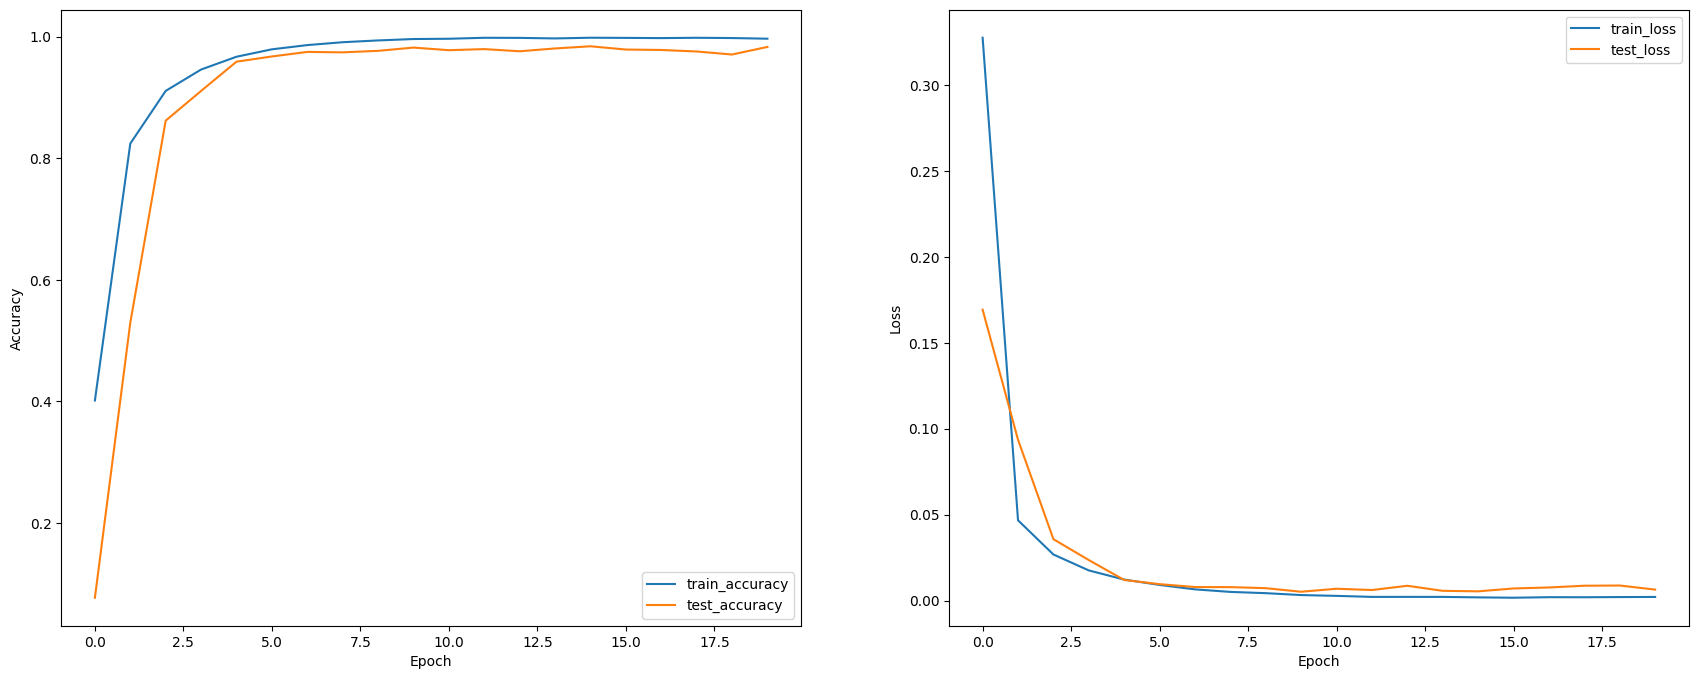

In [31]:
plt.figure(figsize=(21, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label='train_loss')
plt.plot(history.history["val_loss"], label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

Predictions

1/1 [==============================] - 0s 28ms/step
[('M', 0.99959344), ('W', 0.01956209), ('K', 0.0018743371)]


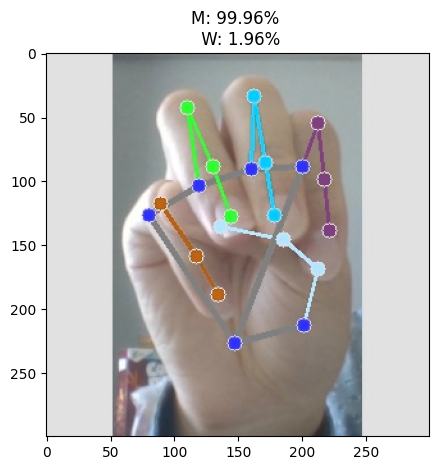

In [34]:
# Read the image using cv2
image = cv.imread("/content/151.jpg")

# Reading image, convert it to np array and decode
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
#image = img_to_array(image)


# Resize, scale and reshape image before making predictions
resized = cv.resize(image, (224,224))
resized = (resized / 255.0).reshape(-1, input_shape[1], input_shape[0], input_shape[2])

classes=['A', 'B', 'C' ,'D' ,'E' ,'F', 'G' ,'H' ,'I', 'J' ,'K' ,'L' ,'M', 'N' ,'O' ,'P', 'Q' ,'R',
 'S' ,'T' ,'U' ,'V' ,'W' ,'X' ,'Y' ,'Z' ,'del' ,'space']



# Predict results
preds = model.predict(resized)
preds = zip(classes, list(preds[0]))
preds = sorted(list(preds), key = lambda z: z[1], reverse = True)[:3]

print(preds)


# Showing image
plt.imshow(image[:, :, ::-1])
plt.title(f'{preds[0][0]}: {round(preds[0][1] * 100, 2)}% \n {preds[1][0]}: {round(preds[1][1] * 100, 2)}%')

plt.tight_layout()